# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Linear regression 

## Manually

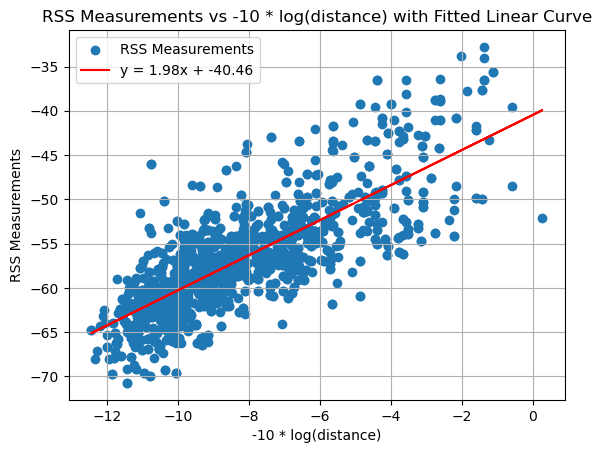

Learned weights via linear regression:
[-40.45586332   1.98171289]
Number of weights learned via regression: 2
Significance of weights:
The learned weights represent the coefficients of the linear curve in the log distance path loss model.P_0, η obtained by least square linear regression


In [2]:
# Get current directory
current_dir = os.getcwd()
dataset_dir = current_dir

# Read locations data
with open(os.path.join(dataset_dir, 'locations.txt'), 'r') as f:
    locations_lr = np.loadtxt(f)

# Read RSS values data
with open(os.path.join(dataset_dir, 'rss_values.txt'), 'r') as f:
    rss_values_lr = np.loadtxt(f)

# Preprocess data
num_transmitters = rss_values_lr.shape[0]
num_sensors = locations_lr.shape[0]
num_measurements_per_transmitter = num_sensors - 1

# Initialize arrays to store preprocessed data
distances = np.zeros((num_transmitters, num_measurements_per_transmitter))
rss_measurements = np.zeros((num_transmitters, num_measurements_per_transmitter))

def transmitter(_array):
    for e_idx, e in enumerate(_array):
        if np.isinf(e):
            return e_idx

# Loop over transmitters
for i in range(num_transmitters):
    transmitter_idx = transmitter(rss_values_lr[i, :])
    transmitter_location = locations_lr[transmitter_idx]
    idx = 0
    # Loop over sensors
    for j in range(num_sensors):
        if j != transmitter_idx:  # Exclude the transmitter itself
            sensor_location = locations_lr[j]
            # Calculate distance between transmitter and sensor
            distance = np.sqrt(np.sum((transmitter_location - sensor_location) ** 2))
            distances[i, idx] = -10 * np.log10(distance)  # Log distance; d_0 = 1
            rss_measurements[i, idx] = rss_values_lr[i, j]
            idx += 1


# Now distances and rss_measurements contain the preprocessed data
# Closed-form expression of least square regression
def least_square_regression(X, y):
    # Add bias term to X
    X = np.column_stack((np.ones(len(X)), X))
    # Compute weights
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w

# Fit linear curve
def linear_curve(X, w):
    # Add bias term to X
    X = np.column_stack((np.ones(len(X)), X))
    # Calculate fitted values
    y_pred = X @ w
    return y_pred

# Perform least square regression
weights = least_square_regression(distances.flatten(), rss_measurements.flatten())

# Plot RSS measurements as a function of log distance
plt.scatter(distances.flatten(), rss_measurements.flatten(), label='RSS Measurements')
# Calculate fitted linear curve
fitted_curve = linear_curve(distances.flatten(), weights)
plt.plot(distances.flatten(), fitted_curve, color='red', label=f'y = {weights[1]:.2f}x + {weights[0]:.2f}')
plt.xlabel('-10 * log(distance)')
plt.ylabel('RSS Measurements')
plt.title('RSS Measurements vs -10 * log(distance) with Fitted Linear Curve')
plt.legend()
plt.grid(True)
plt.show()
# Report the learned weights
print("Learned weights via linear regression:")
print(weights)
print("Number of weights learned via regression:", len(weights))
print("Significance of weights:")
print("The learned weights represent the coefficients of the linear curve in the log distance path loss model.P_0, η obtained by least square linear regression")


## using inbuilt function

Mean squared error: 14.792179823288686
Mean absolute error: 2.9499455999461714


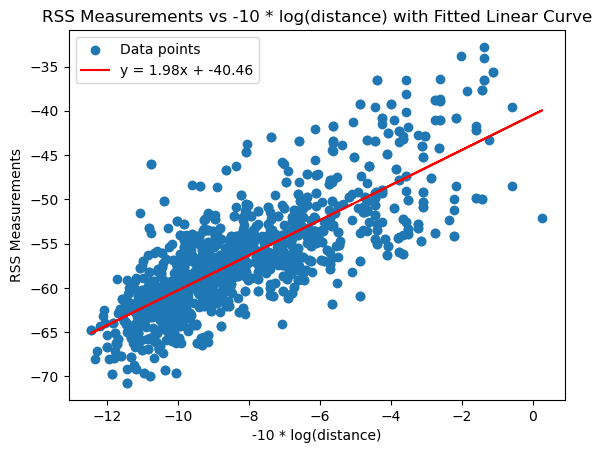

In [3]:
# calculating m and c 
x_lr = np.array(distances.flatten()).reshape(-1, 1)
y_lr = np.array(rss_measurements.flatten())

model_lr = LinearRegression()
model_lr.fit(x_lr, y_lr)

m = model_lr.coef_[0]
c = model_lr.intercept_

mse_lr = mean_squared_error(y_lr, model_lr.predict(x_lr))
mae_lr = mean_absolute_error(y_lr, model_lr.predict(x_lr))

print("Mean squared error:", mse_lr)
print("Mean absolute error:", mae_lr)

plt.scatter(x_lr, y_lr, label='Data points')
plt.plot(x_lr, model_lr.predict(x_lr), color='red',label=f'y = {m:.2f}x + {c:.2f}')
plt.xlabel('-10 * log(distance)')
plt.ylabel('RSS Measurements')
plt.title('RSS Measurements vs -10 * log(distance) with Fitted Linear Curve')
plt.legend()
plt.show()


## predicting all rss_values for all remaining sensors 

In [4]:
def predict_rss(locations, m, c, label, sensor):
    if label == sensor:
        return math.inf  # if same sensor
    x1, y1 = locations[label]
    x2, y2 = locations[sensor]
    d = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    if d == 0:
        return math.inf  
    log_d = -10 * np.log10(d)
    return m * log_d + c

# Define function to predict RSS values for remaining sensors
def predict_rss_array(locations, m, c, rss_value_labels, num_sensors):
    predicted_rss_array = []

    missing_sensor_indices = [i for i in range(num_sensors) if i not in rss_value_labels]

    for label in missing_sensor_indices:
        predicted_rss_values = []
        for sensor in range(num_sensors):
            rss_prediction = predict_rss(locations, m, c, label, sensor)
            predicted_rss_values.append(rss_prediction)
        predicted_rss_array.append(predicted_rss_values)

    return predicted_rss_array

rss_value_labels = [j for i, row in enumerate(rss_values_lr) for j, value in enumerate(row) if value == math.inf]
NUM_SENSORS=44

# Predict the RSS array for remaining sensors
predicted_rss_array = predict_rss_array(locations_lr, m, c, rss_value_labels, NUM_SENSORS)

# Initialize lists to store sensor indices and predicted RSS values
sensor_indices_lr = []
rss_values_lr = []

# Print predicted RSS values for each missing sensor
missing_sensor_indices = [i for i in range(NUM_SENSORS) if i not in rss_value_labels]
for i, sensor_index in enumerate(missing_sensor_indices):
    predicted_rss_values = predicted_rss_array[i]
    print(f'Sensor {sensor_index}: {predicted_rss_values}')
    sensor_indices_lr.append(sensor_index)
    rss_values_lr.append(predicted_rss_values)


# Convert lists to NumPy arrays if needed
sensor_indices_lr = np.array(sensor_indices_lr)
rss_values_lr = np.array(rss_values_lr)



Sensor 0: [inf, -50.05302591581943, -41.60617294978289, -54.330801640291405, -51.82995134873091, -54.11054538660631, -51.13717625240061, -58.23607583258931, -61.08688451226868, -60.77827669614115, -61.94923304420085, -62.49768462068661, -63.022227117210164, -61.96747355841123, -60.162326334642096, -58.23968441549901, -57.5865457507804, -56.69399352068912, -54.77254657535255, -56.433111534250145, -59.93491483971438, -56.52542421328125, -60.732037334189556, -62.192066819885255, -61.459298065242706, -60.13454849832115, -59.92517350025699, -61.443907977784036, -63.235290599785166, -63.81668073819362, -64.82637835111544, -64.37931387361117, -63.68133196738658, -63.324734918710504, -63.05062360101353, -63.07925567813205, -61.45075481274901, -62.06198800670214, -62.536611275029884, -62.383540976127435, -63.5949145930593, -64.46760164152492, -63.80581023441222, -65.47442104932009]
Sensor 4: [-51.82995134873091, -47.942566048668525, -48.894902062616055, -42.92935183100923, inf, -47.571723181389

## take user input tx(x y) and rx(x y,x y,.... or enter for all sensors) and predicting rss_values for sensors

In [5]:
import numpy as np
import math

# Function to calculate the Euclidean distance between two points
def calculate_distance(loc1, loc2):
    return np.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

# Function to find the closest sensor location from user input
def find_closest_sensor(input_location, sensor_locations):
    distances = np.linalg.norm(sensor_locations - input_location, axis=1)
    return np.argmin(distances)

# Function to calculate the log-distance between two points
def log_distance(tx_loc, rx_loc):
    distance = calculate_distance(tx_loc, rx_loc)
    if distance == 0:
        return float('inf')  # Avoid log(0) which is undefined
    return -10 * np.log10(distance)

# Load sensor locations
sensor_locations_lr = np.loadtxt('locations.txt')

# User input for transmitter location
tx_input_lr = input("Enter TX location (format: x y): ")
tx_loc_lr = np.array(list(map(float, tx_input_lr.split())))

# User input for receiver locations
rx_input_lr = input("Enter RX locations (format: x y, x y, ...) or press Enter for all sensors: ")

if rx_input_lr.strip():
    rx_locs_lr = np.array([list(map(float, loc.split())) for loc in rx_input_lr.split(',')])
else:
    # Exclude the transmitter itself if it's in the list of sensor locations
    tx_index_lr = find_closest_sensor(tx_loc_lr, sensor_locations_lr)
    rx_locs_lr = np.array([loc for i, loc in enumerate(sensor_locations_lr) if i != tx_index_lr])


m = weights[1]  #  slope (gradient) of the line
c = weights[0]  #  y-intercept of the line

# Function to make predictions based on the linear regression model
def predict_rss_linear_regression(tx_loc, rx_locs, m, c):
    predictions = {}
    for rx_loc in rx_locs:
        log_d = log_distance(tx_loc, rx_loc)
        if log_d == float('inf'):
            rss_pred = 'Same location as transmitter'
        else:
            rss_pred = m * log_d + c
        predictions[tuple(rx_loc)] = rss_pred
    return predictions

# Make predictions
predicted_rss_values_lr = predict_rss_linear_regression(tx_loc_lr, rx_locs_lr, m, c)

# Output the results
for loc, rss in predicted_rss_values_lr.items():
    print(f"Predicted RSS for RX location {loc} is: {rss}")


Predicted RSS for RX location (-3.2004, 7.3152) is: -58.54258453409544
Predicted RSS for RX location (-3.6576, 8.6868) is: -59.932481571418
Predicted RSS for RX location (-2.7432, 4.3434) is: -54.96207745904191
Predicted RSS for RX location (-0.9144, 1.6002) is: -46.87236605732074


# DL Code

In [6]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

locations = np.loadtxt('locations.txt').tolist()
rss_values = np.loadtxt('rss_values.txt').tolist()

# Prepare training data
X = []
y = []


def get_current_sensor(array):
    for i in range(len(array)):
        if array[i] == math.inf:
            return i
# Iterate through the rss_values matrix to calculate distances between sensor pairs (i and j) using their coordinates from locations.
for rss_value_array in rss_values:
    sensor = get_current_sensor(rss_value_array)
    for other_sensor, rss_value in enumerate(rss_value_array):
        xc = locations[sensor] # coordinates of first sensor
        yc = locations[other_sensor] # coordinates of second sensor

        d = math.sqrt(math.pow((xc[0]-yc[0]),2) + math.pow((xc[1]-yc[1]),2))
        if d>0:
            log_d = -10*np.log10(d)
            X.append(log_d)
            y.append(rss_value)

# clean up the data and remove inf values
inf_positions = np.isinf(y)
y = np.delete(y, np.where(inf_positions))
X = np.delete(X, np.where(inf_positions))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## making neural network 

In [7]:
# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer (single output for RSS value)
])
# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer)
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_split=0.2)


Epoch 1/200
117/117 [==============================] - 1s 4ms/step - loss: 2875.2446 - val_loss: 2714.4514
Epoch 2/200
117/117 [==============================] - 0s 2ms/step - loss: 2559.1714 - val_loss: 2404.0767
Epoch 3/200
117/117 [==============================] - 0s 2ms/step - loss: 2229.1257 - val_loss: 2042.8365
Epoch 4/200
117/117 [==============================] - 0s 2ms/step - loss: 1841.0292 - val_loss: 1639.3472
Epoch 5/200
117/117 [==============================] - 0s 2ms/step - loss: 1435.8829 - val_loss: 1236.3378
Epoch 6/200
117/117 [==============================] - 0s 3ms/step - loss: 1038.3379 - val_loss: 831.8543
Epoch 7/200
117/117 [==============================] - 0s 3ms/step - loss: 654.2938 - val_loss: 500.1316
Epoch 8/200
117/117 [==============================] - 0s 3ms/step - loss: 386.0527 - val_loss: 294.1409
Epoch 9/200
117/117 [==============================] - 0s 3ms/step - loss: 231.3485 - val_loss: 187.6653
Epoch 10/200
117/117 [======================

In [8]:
# Evaluate the model on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_error
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics (e.g., MSE, MAE)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


10/10 [==============================] - 0s 2ms/step - loss: 13.0107
Test Loss: 13.010727882385254
10/10 [==============================] - 0s 2ms/step
Mean Squared Error: 13.010727348987619
Mean Absolute Error: 2.811675029940417


In [9]:
#save the model
model.save('model.h5')
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


c:\Users\Monika Singh\anaconda2\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


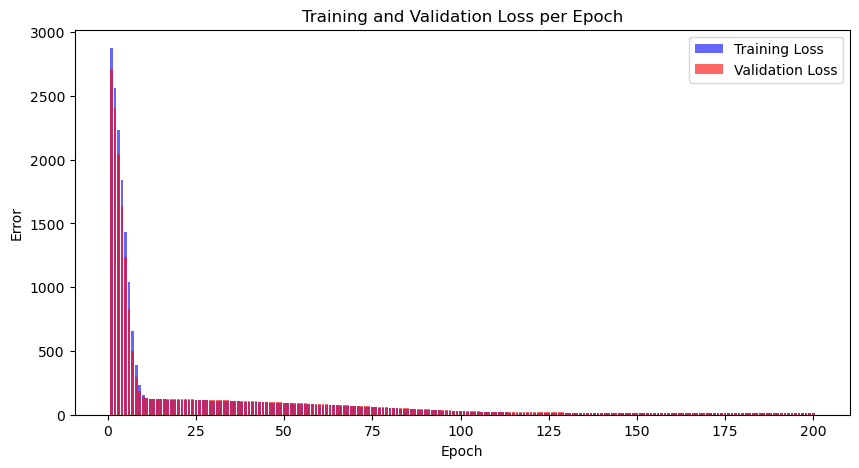

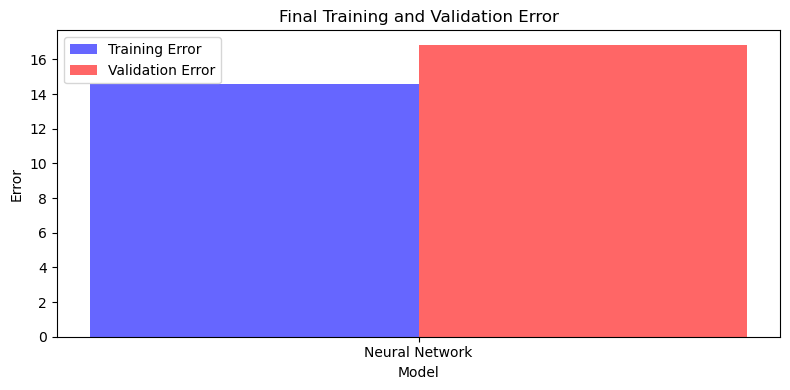

In [10]:
# Extract training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Assuming you want to display the last epoch loss
train_error_final = training_loss[-1]
val_error_final = validation_loss[-1]

# Creating indices for each pair of training and validation loss
indices = range(1, len(training_loss) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(indices, training_loss, color='blue', label='Training Loss', alpha=0.6)
plt.bar(indices, validation_loss, color='red', label='Validation Loss', alpha=0.6)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()


# Plotting the final error as a simple bar chart
plt.figure(figsize=(8, 4))
bar_width = 0.35
index = np.arange(1)  # This creates an array with one element for indexing bar positions

# Creating bars
bar1 = plt.bar(index, train_error_final, bar_width, label='Training Error', color='b', alpha=0.6)
bar2 = plt.bar(index + bar_width, val_error_final, bar_width, label='Validation Error', color='r', alpha=0.6)

plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Final Training and Validation Error')
plt.xticks(index + bar_width / 2, ['Neural Network'])  # Corrected to match the number of bars
plt.legend()
plt.tight_layout()
plt.show()



## predicting all rss_values for all remaining sensors 

In [11]:
def predict_rss_dl(locations, model, missing_sensor_indices):
    # Predict RSS values for each missing sensor
    predicted_rss_values = []
    # Iterate over each missing sensor index
    for label in missing_sensor_indices:
        rss_predictions = []
        # Calculate log distance and predict RSS for each sensor
        for sensor in range(len(locations)):
            if sensor != label:
                # Calculate Euclidean distance between sensors
                x1, y1 = locations[label]
                x2, y2 = locations[sensor]
                distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                # Calculate log distance (normalized)
                log_distance = -10 * np.log10(distance)
                # Reshape log distance for model prediction
                log_distance_array = np.array([[log_distance]])
                # Predict RSS using the model
                
                rss_prediction = model.predict(log_distance_array)[0][0]
                
                rss_predictions.append(rss_prediction)
            else:
                rss_predictions.append(math.inf)
        predicted_rss_values.append(rss_predictions)

    return predicted_rss_values
    
rss_value_labels_dl = [j for i, row in enumerate(rss_values) for j, value in enumerate(row) if value == math.inf]
NUM_SENSORS_dl=44

# Get indices of missing sensors (not in rss_value_labels)
missing_sensor_indices_dl = [i for i in range(len(locations)) if i not in rss_value_labels_dl]
# Predict RSS values for missing sensors
predicted_rss_values_dl = predict_rss_dl(locations, model, missing_sensor_indices_dl)

# Initialize lists to store sensor indices and predicted RSS values
sensor_indices_dl = []
rss_values_dl = []

# Print predicted RSS values for each missing sensor
for i, sensor_index in enumerate(missing_sensor_indices_dl):
    print(f'Sensor {sensor_index}: {predicted_rss_values_dl[i]}')
    sensor_indices_dl.append(sensor_index)
    rss_values_dl.append(predicted_rss_values_dl[i])

sensor_indices_dl=np.array(sensor_indices_dl)
rss_values_dl=np.array(rss_values_dl)
    

1/1 [==============================] - 0s 31ms/step
Sensor 0: [inf, -50.197662, -40.429348, -54.158432, -51.842915, -53.9545, -51.201473, -57.80589, -61.213753, -60.84485, -62.26751, -62.992386, -63.685665, -62.291622, -60.108536, -57.810204, -57.172913, -56.346504, -54.567436, -56.104954, -59.83668, -56.190414, -60.78958, -62.588455, -61.658943, -60.075333, -59.825047, -61.640545, -63.967262, -64.73567, -66.07017, -65.4793, -64.55679, -64.08548, -63.723198, -63.76104, -61.64873, -62.416527, -63.043835, -62.841522, -64.44258, -65.595985, -64.721306, -66.94014]
Sensor 4: [-51.842915, -48.243603, -49.125362, -42.21447, inf, -47.90024, -46.05962, -53.9545, -57.472336, -57.472336, -59.43462, -59.63202, -60.279434, -58.484146, -55.87482, -54.183205, -55.537918, -53.00392, -50.24218, -54.256607, -56.65473, -50.661972, -57.074524, -59.015533, -57.675194, -55.76565, -55.394745, -57.664314, -60.610092, -61.543392, -63.260677, -62.751637, -61.90399, -61.64873, -61.689453, -62.02011, -59.574207, 

## take user input tx(x y) and rx(x y,x y,.... or enter for all sensors) and predicting rss_values for sensors

In [12]:
import numpy as np
import tensorflow as tf

# Function to calculate Euclidean distance between two points
def calculate_distance(loc1, loc2):
    return np.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

# Function to find the closest sensor location from user input
def find_closest_sensor(input_location, sensor_locations):
    distances = np.linalg.norm(sensor_locations - input_location, axis=1)
    return np.argmin(distances)

# Load sensor locations
sensor_locations = np.loadtxt('locations.txt')

# User inputs for transmitter and optionally specified receiver locations
tx_location = np.array(list(map(float, input("Enter TX location (format: x y): ").split())))
tx_index = find_closest_sensor(tx_location, sensor_locations)

# User input for receiver locations
rx_locations_input = input("Enter RX locations (format: x y, x y, ... or leave empty for all sensors except TX): ")

if rx_locations_input:
    rx_locations = np.array([list(map(float, loc.split())) for loc in rx_locations_input.split(',')])
    rx_indices = [find_closest_sensor(rx_loc, sensor_locations) for rx_loc in rx_locations]
else:
    rx_indices = list(range(len(sensor_locations)))
    rx_indices.remove(tx_index)  # Exclude the transmitter from the receivers

# Load the deep learning model
model = tf.keras.models.load_model('model.h5')

def predict_rss_dl(tx_index, rx_indices, locations, model):
    predicted_rss_values = []
    tx_loc = locations[tx_index]  # Get the transmitter location from the index

    for rx_index in rx_indices:
        rx_loc = locations[rx_index]
        distance = calculate_distance(tx_loc, rx_loc)
        # Small distance threshold to handle computational limits similarly to linear regression
        if distance < 0.01:  # Adjust this threshold based on what's considered "near zero" in your context
            distance = 0.01
        log_distance = -10 * np.log10(distance)
        log_distance_array = np.array([[log_distance]])  # Reshape for model prediction
        rss_prediction = model.predict(log_distance_array)[0][0]
        predicted_rss_values.append(rss_prediction)

    return predicted_rss_values

# Predict RSS values for the specified or all receivers
predicted_rss_values_dl = predict_rss_dl(tx_index, rx_indices, sensor_locations, model)

# Output predicted RSS values
for i, rx_index in enumerate(rx_indices):
    print(f'Sensor {rx_index}: {predicted_rss_values_dl[i]}')


1/1 [==============================] - 0s 20ms/step
Sensor 5: -58.17229080200195
Sensor 6: -59.833778381347656
Sensor 7: -54.742919921875
Sensor 8: -47.14521789550781


## plotting graph for comparison b/w LR nd Dl output 

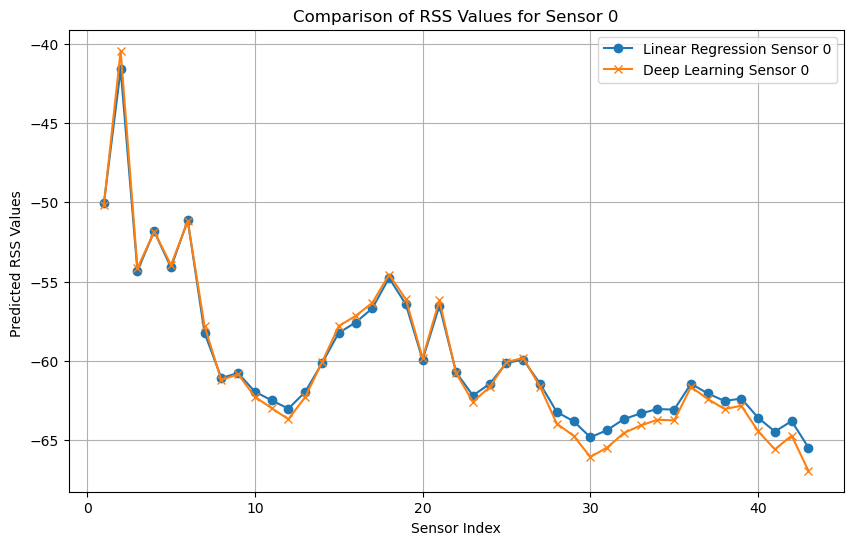

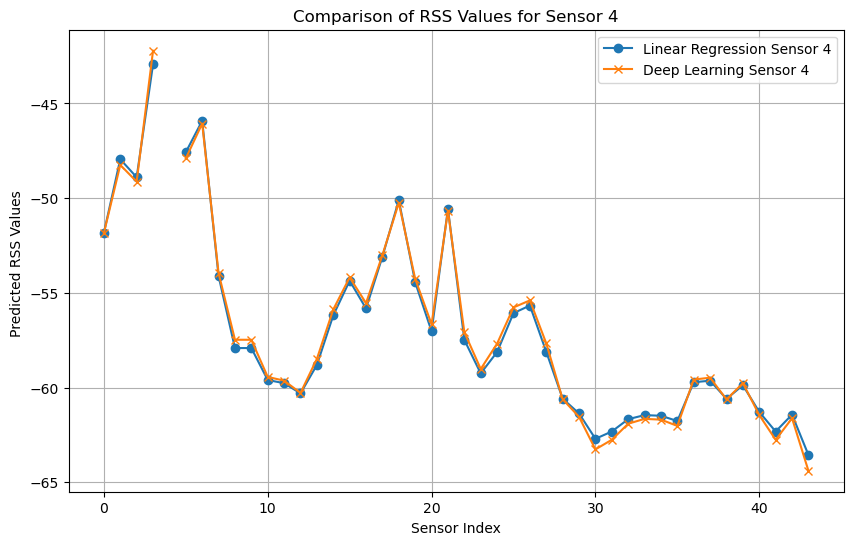

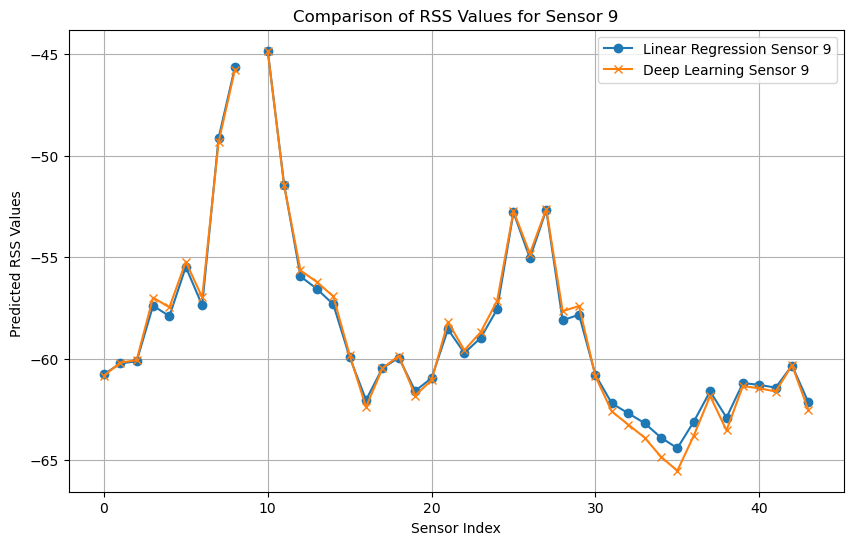

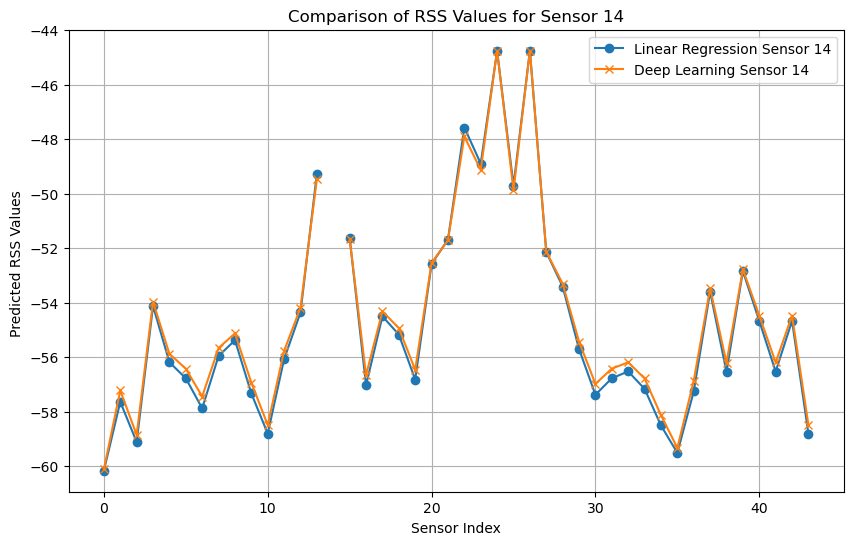

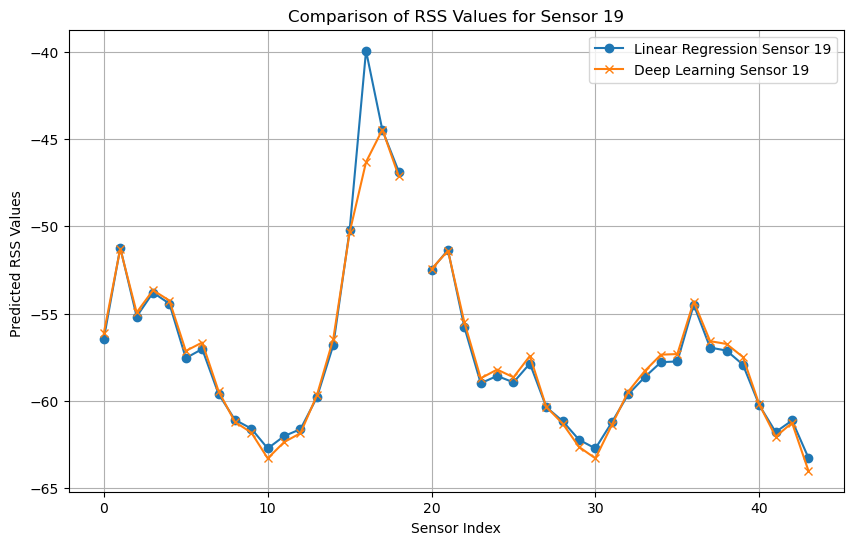

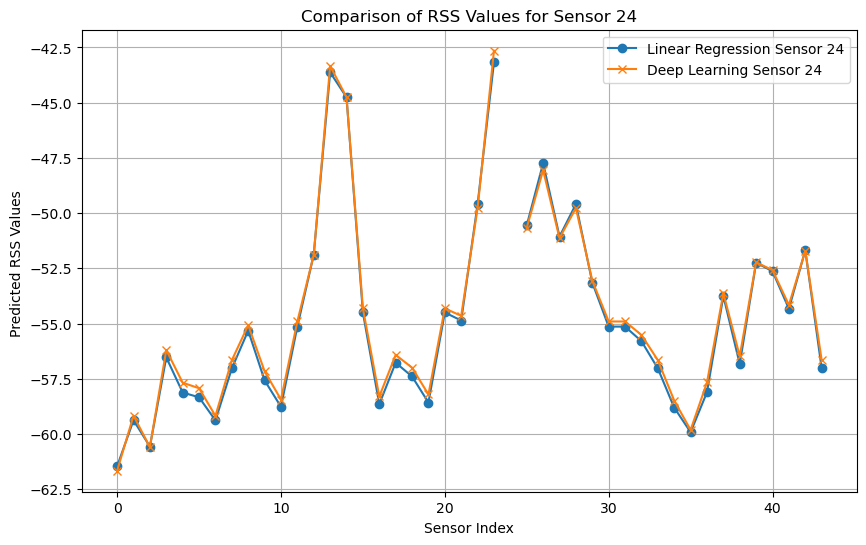

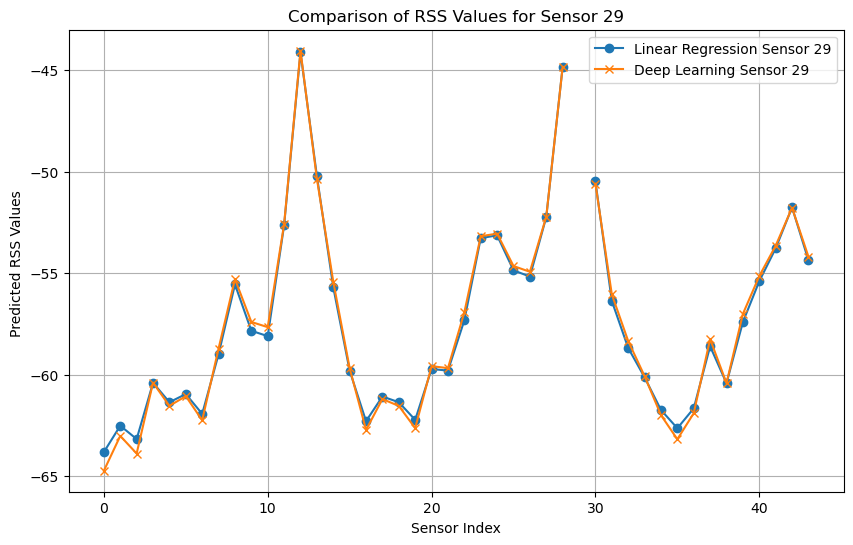

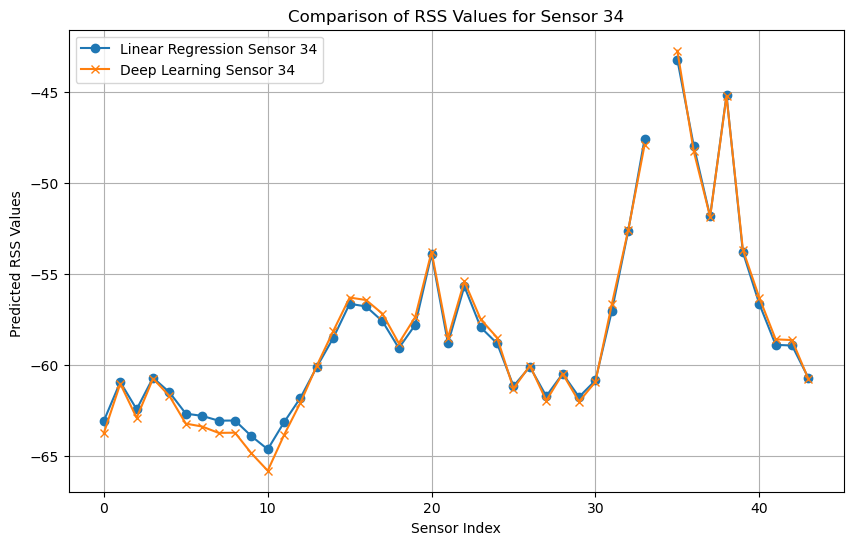

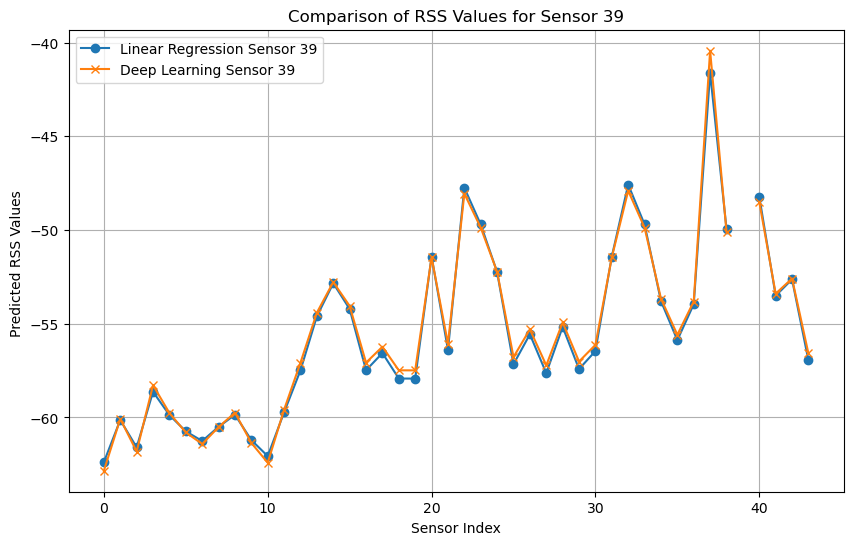

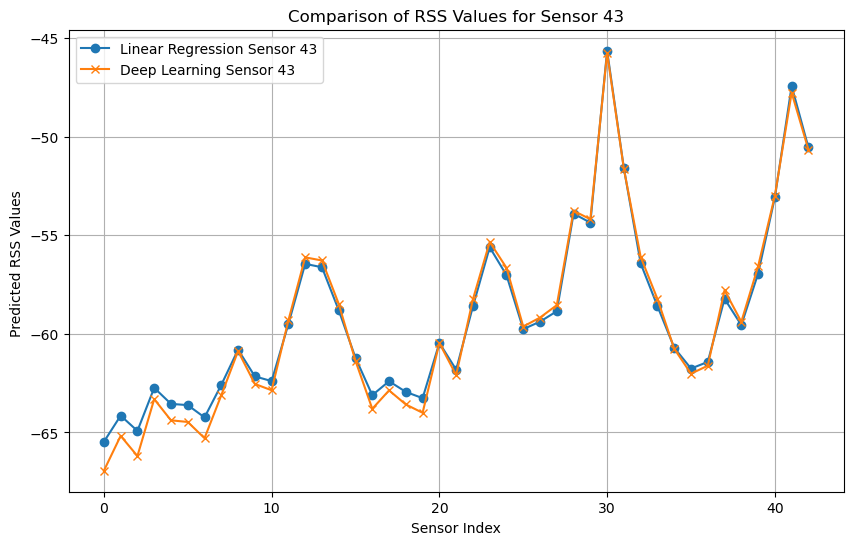

In [13]:
import matplotlib.pyplot as plt

# Iterate over each sensor index for plotting
for i in range(len(sensor_indices_dl)):
    sensor_index_dl = sensor_indices_dl[i]
    sensor_index_lr = sensor_indices_lr[i]
    
    # Ensure the sensor indices match
    if sensor_index_dl == sensor_index_lr:
        # Get the corresponding RSS values for Deep Learning and Linear Regression
        rss_value_dl = rss_values_dl[i]
        rss_value_lr = rss_values_lr[i]
        
        # Plot RSS values for the current sensor index
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(rss_value_lr)), rss_value_lr, marker='o', label='Linear Regression '+f'Sensor {sensor_index_lr}')
        plt.plot(range(len(rss_value_dl)), rss_value_dl, marker='x', label='Deep Learning '+f'Sensor {sensor_index_dl}')
        plt.xlabel('Sensor Index')
        plt.ylabel('Predicted RSS Values ')
        plt.title(f'Comparison of RSS Values for Sensor {sensor_index_dl}')
        plt.legend()
        plt.grid(True)
        plt.show()


## printing weights and biases of model

In [14]:
# print weight and bias
for layer in model.layers:
    weights, biases = layer.get_weights()
    print("Weights:", weights)
    print("Biases:", biases)


Weights: [[ 0.4059168  -0.10281274 -0.26666573 -0.00340388 -0.2000609   0.48282397
  -0.2158138   0.47526962  0.06988182 -0.01493524  0.1798524   0.44133312
  -0.29540983 -0.18171053 -0.02560504  0.03891667  0.28423527  0.2032492
   0.02127764 -0.27264038  0.5050268  -0.07688894  0.08650041 -0.12167161
   0.01502029  0.40524134 -0.12804385 -0.2411205   0.03075475  0.25023383
  -0.27607834  0.39654052 -0.23208739 -0.21196124 -0.35425273  0.05065613
   0.42666134 -0.226753    0.00505536 -0.15246788  0.11936482 -0.03216223
   0.02113661 -0.18995413 -0.20307766  0.43842623 -0.16828974  0.46811637
  -0.06605924  0.364772   -0.2581371   0.0214949   0.09142978 -0.10940158
   0.38289905 -0.14598456 -0.21375649  0.4011518  -0.27901557 -0.04650717
  -0.02588727  0.06580606 -0.30389202 -0.12090566]]
Biases: [ 0.20051038  0.69098616  0.61868984  0.73985445  0.6467514   0.21001066
  0.62067205  0.17259686 -0.0191802   0.66447777 -0.04700765  0.2000042
  0.63804835  0.6224149   0.72838044 -0.0106829

# Thank you :(